# model

Please refer to README file for project overview.

In [1]:
data_dir = "../../../DATA/behavioral_cloning_data/"

In [2]:

import matplotlib.image as mpimg
from scipy import misc
import matplotlib.pyplot as plt
import cv2

In [3]:
import DataHelper
#print(DataHelper.__doc__)
from DataHelper import test_read_csv, read_csv
#print(read_csv.__doc__)
#test_read_csv()
# fetch actual log of driving data
headers, data = read_csv(data_dir + "driving_log.csv")

Using TensorFlow backend.


imported rows 8037


# Labels (steering value classes)

- Please review notebook "preprocessing", section: "Steering value distribution".
- Training labels have values ranging from -1 to +1.
- When you steer with **keyboard** the STEPS are rather corse, so I think I can get away with **discrete steering angles, i.e. classes**.
- I will start training with 21 equally spread classes, if needed I will increase to 41.
- I want to make sure that my classes include **0.0 (zero)** as it is most common value.

steering_classes [-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9  1. ]
Number of classes 21


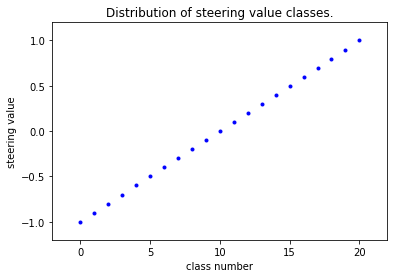

In [4]:
import numpy as np
from numpy import ndarray
number_of_classes = 21
steering_classes = np.linspace(-1, 1, num=number_of_classes, endpoint=True) 
steering_classes = np.sort(steering_classes)
print("steering_classes", steering_classes)
print("Number of classes",steering_classes.shape[0])

import matplotlib.pyplot as plt
plt.plot(steering_classes, 'b.')
plt.margins(0.1)
plt.title("Distribution of steering value classes.")
plt.xlabel("class number")
plt.ylabel('steering value')
plt.show()

# Split data into training, testing and validation sets

In [5]:
from DataHelper import split_random, get_image_center_values
image_center_values = get_image_center_values(data)

training, testing, validation = \
split_random(data, percent_train=70, percent_test=15) 

print("training",training.shape)
print("testing",testing.shape)
print("validation",validation.shape)

percent_validation 15
training (5626, 7)
testing (1206, 7)
validation (1204, 7)


# Extract training features (images)

In [6]:
from DataHelper import get_image_center_values 
image_names = get_image_center_values(training)
print(image_names.shape)
print(image_names[1])

(5626,)
IMG/center_2016_12_01_13_43_39_086.jpg


## Create a list of image paths pointing to 64px version

In [7]:
image_paths = []
for image_name in image_names:
    image_paths.extend([data_dir + "processed_images_64/" + image_name])
print(image_paths[1]) 

../../../DATA/behavioral_cloning_data/processed_images_64/IMG/center_2016_12_01_13_43_39_086.jpg


matrix shape (5626, 14, 64, 3)


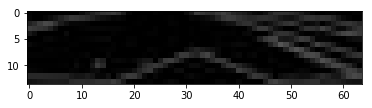

In [8]:
from DataHelper import read_image
training_features = np.array([ read_image(path) for path in image_paths] )

print ("matrix shape", training_features.shape)
plt.imshow(training_features[2], cmap='gray')
plt.show()

In [9]:
from DataHelper import normalize_grayscale

training_features_normalized = normalize_grayscale(training_features)

# Extract training labels (steering value classes) 

In [10]:
from DataHelper import get_steering_values, find_nearest
raw_labels = get_steering_values(training)
print(raw_labels.shape)
print(raw_labels[0:5])

training_labels = np.array([], dtype=np.float64)

for raw_label in raw_labels: # raw_labels[:5]
    #print("raw_label", raw_label)
    label = find_nearest(steering_classes, raw_label)
    #print("normalized label", label)
    
    # Classification labels should be strings:
    training_labels = np.append(training_labels, [str(label)])
        
print(training_labels)

(5626,)
[ 0.        -0.1452064 -0.0787459  0.         0.       ]
['0.0' '-0.1' '-0.1' ..., '0.0' '0.0' '0.0']


## One hot

In [11]:
import sklearn
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_one_hot = label_binarizer.fit_transform(training_labels)
print(y_one_hot)

[[0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


# Extract 

# Keras (with TensorFlow)

In [12]:
import keras.backend as K
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Activation

from keras.activations import relu, softmax
from keras.optimizers import SGD
import cv2, numpy as np
from DataHelper import mean_pred, false_rates

In [13]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Convolution1D
    
def build_model(weights_path=None):
    """
    The cropped camera images are expected to be (3, 14, 64), not square
    e.g.: 
    - training_features_normalized (5626, 14, 64, 3)
    - y_one_hot (5626, 18)
    
    https://keras.io/layers/convolutional/
    """
    output_dim = 21 # number of classes
    model = Sequential()
    
    # IN: (samples, rows, cols, channels)'tf'
    # expected 01_Conv2D to have 4 dimensions, but got array with shape (5626, 18)
    # expected 01_Conv2D to have 4 dimensions, but got array with shape (5626, 1)
    model.add(Convolution2D(96, 14, 64, dim_ordering='tf', input_shape=(14, 64, 3), activation='relu', name="01_Conv2D"))
    # Output shape of convolution is 4d
    
    #expected flatten_2 to have shape (None, 96) but got array with shape (5626, 18)
    #model.add(Flatten()) 
    # Flatten input into 2d

    # Dense layer require a 2d input
    # have shape (None, 21) but got array with shape (5626, 1)
    #model.add(Dense(18, activation='sigmoid', name="001_Dense"))

    if weights_path:
        model.load_weights(weights_path)
    return model


print("training_features_normalized", training_features_normalized.shape)
print("y_one_hot", y_one_hot.shape)
model = build_model()

# Before training a model, you need to configure the learning process, which is done via the compile method.
optimizer='sgd' # | 'rmsprop'
loss_function='mean_squared_error' # | 'binary_crossentropy' | 'mse'
metrics_array=['accuracy', mean_pred, false_rates]
model.compile(optimizer, loss_function, metrics_array)

history = model.fit(training_features_normalized, training_labels, nb_epoch=3, verbose=1,validation_split=0.2)
#history = model.fit(training_features_normalized, y_one_hot, nb_epoch=3, validation_split=0.2)

#Epoch 20/20 loss: 0.0518 - acc: 0.60 - val_loss: 0.05 - val_acc: 0.59

training_features_normalized (5626, 14, 64, 3)
y_one_hot (5626, 18)


Exception: Error when checking model target: expected 01_Conv2D to have 4 dimensions, but got array with shape (5626, 1)